In [47]:
%matplotlib inline
%run analyze_traj.py
data_dir='/home/amichaut/Desktop/charlene'
df=run(data_dir,refresh=False)
df2=filter_by_traj_len(df,min_traj_len=25)

In [48]:
#### PLOT VFIELD
groups=df2.groupby('frame')
for frame in df['frame'].unique():
    avg_vfield=plot_frame_vfield(df,groups,frame,data_dir,avg_grid=10,plot_field=False)
    div=plot_frame_div(avg_vfield,frame,data_dir)

plotting frame 24.0


In [30]:
#### PLOT TRAJ

# tracks=df.groupby('traj')
# long_tracks=[]
# for t in df['traj'].unique():
#     track=tracks.get_group(t)
#     if track.shape[0]==25:
#         long_tracks.append(t)
# print len(long_tracks)
z_lim=[df['z_rel'].min(),df['z_rel'].max()]
groups=df2.groupby('frame')
for frame in df['frame'].unique():
    plot_frame_cells(df2,groups,frame,data_dir,z_lim=z_lim,plot_traj=True,hide_labels=True)


plotting frame 24.0


In [60]:
#### GENERATE SYNTHETIC DATA

part_num=10
frame_num=25
x0=10;y0=10;z0=10
xmax=100;ymax=100;zmax=100;
shift=50
traj=array([]);frame=array([]);x=array([]);y=array([]);z=array([])
for i in range(part_num):
    traj=np.concatenate((traj,ones(frame_num)*i))
    frame=np.concatenate((frame,arange(frame_num)))
    x=np.concatenate((x,linspace(x0,xmax,frame_num)))
    y=np.concatenate((y,linspace(y0+i*shift,ymax+i*shift,frame_num)))
    z=np.concatenate((z,linspace(z0,zmax,frame_num)))

a=np.vstack([arange(frame_num*part_num),traj,frame,x,y,z,zeros((6,frame_num*part_num))]).T
    
df=pd.DataFrame(a,columns=['i','traj','frame','x','y','z','m0','m1','m2','m3','m4','NPscore'])
savetxt('test_data.txt',a,delimiter='\t')

[-1, 7, -1, 7]

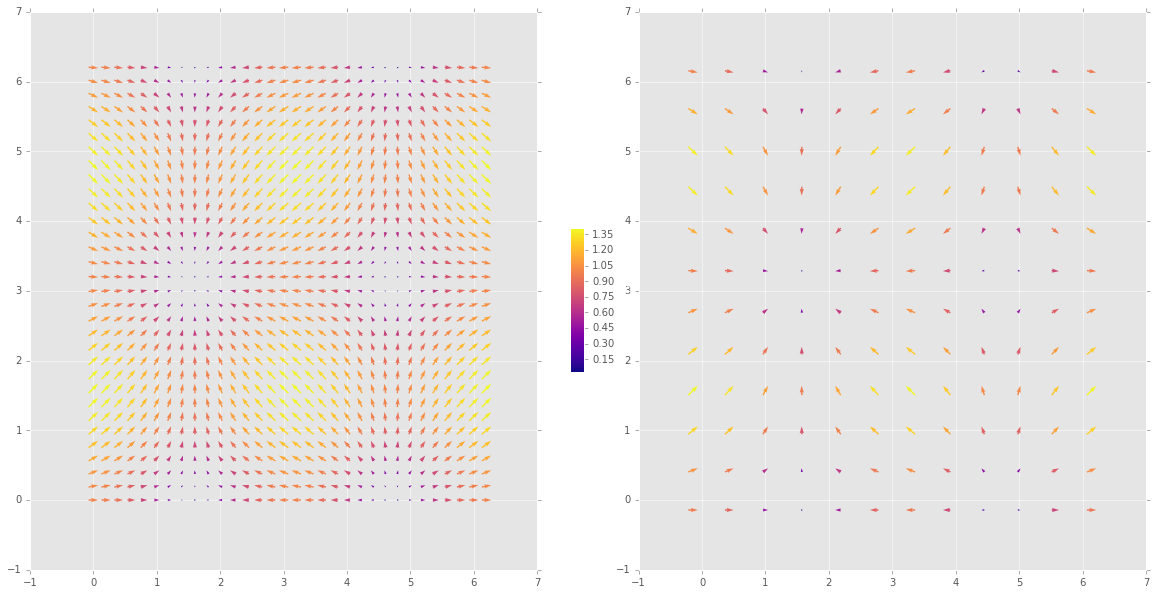

In [91]:
### TEST QUIVER

X, Y = np.meshgrid(np.arange(0, 2 * np.pi, .2), np.arange(0, 2 * np.pi, .2))
U = np.cos(X)
V = np.sin(Y)
fig, (ax, ax1) = plt.subplots(ncols=2, figsize=(20, 10))
M = np.hypot(U, V)
Q = ax.quiver(X, Y, U, V, M,
               units='x',
               pivot='mid',
               width=0.022,
               scale=1 / 0.15,
              cmap='plasma')

xmin, ymin, xmax, ymax=ax.axis()

cbaxes = fig.add_axes([0.5, 0.4, 0.01, 0.2]) 
cbar = fig.colorbar(Q,cax = cbaxes,label='$v_z\ (\mu m.min^{-1})$')
cbaxes.yaxis.label.set_color('white')
ax.axis([-1, 7, -1, 7])

### average grid

a=hstack([X.reshape(32*32,1),Y.reshape(32*32,1),U.reshape(32*32,1),V.reshape(32*32,1),M.reshape(32*32,1)])
df=pd.DataFrame(a,columns=['x','y','vx','vy','vz'])

#make subgrid
res=15
xmin, xmax, ymin, ymax = [-1, 7, -1, 7]
xsubgrid=linspace(xmin,xmax,res);ysubgrid=linspace(ymin,ymax,res)
X=[];Y=[];VX=[];VY=[];VZ=[] #new data
for i,xg in enumerate(xsubgrid[:-1]):
    for j,yg in enumerate(ysubgrid[:-1]):
        xg1=xsubgrid[i+1];yg1=ysubgrid[j+1]
        ind=((df['x']>=xg) & (df['x']<xg1) & (df['y']>=yg) & (df['y']<yg1))
        VX.append(df[ind]['vx'].mean());VY.append(df[ind]['vy'].mean());VZ.append(df[ind]['vz'].mean())
        X.append(xg+(xg1-xg)*0.5);Y.append(yg+(yg1-yg)*0.5) #center of the cell

Q = ax1.quiver(X,Y,VX,VY,VZ,
               units='x',
               pivot='mid',
               width=0.022,
               scale=1 / 0.15,
              cmap='plasma')

ax1.axis([-1, 7, -1, 7])

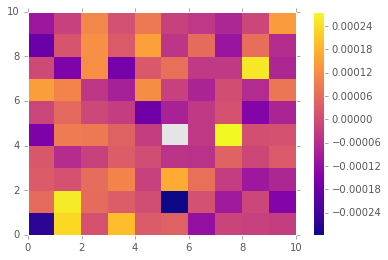

In [20]:
a=np.random.randn(10,10)*1e-4
a[4,5]=np.nan
cmap=cm.plasma
cmap.set_bad('w',alpha=0)
masked_array = np.ma.array (a, mask=np.isnan(a))
A=pcolormesh(masked_array,cmap=cmap)
colorbar(A)

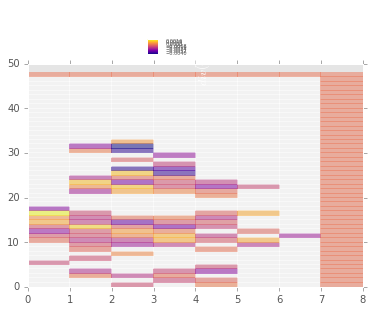

In [35]:
fig=figure(frameon=False); ax=gca()
div_masked = np.ma.array (div, mask=np.isnan(div))
cmap=cm.plasma; cmap.set_bad('w',alpha=0) #set NAN transparent
C=ax.pcolormesh(div_masked[1:-1,1:-1],cmap=cmap,alpha=0.5)
cbaxes = fig.add_axes([0.4, 0.935, 0.025, 0.05])
cbar = fig.colorbar(C,cax = cbaxes,label='$div(\overrightarrow{v})\ (min^{-1})$')
cbaxes.tick_params(labelsize=5,color='w')
cbaxes.yaxis.label.set_color('white')

[-0.5, 847.5, -0.5, 4249.5]

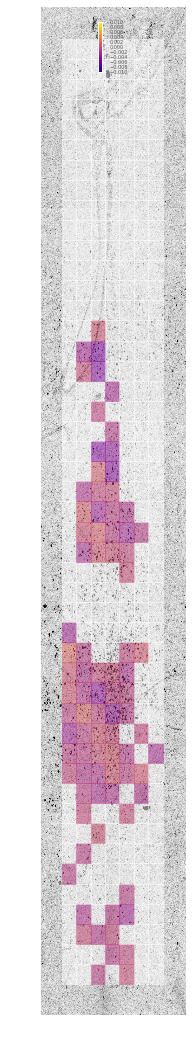

In [46]:
track_dir=osp.join(data_dir,'divergence')
if osp.isdir(track_dir)==False:
    os.mkdir(track_dir)

#import image
filename=osp.join(data_dir,'raw/max_intensity_%04d.png'%int(frame))
im = io.imread(filename)
n,m,d = im.shape
fig=figure(frameon=False)
fig.set_size_inches(m/300,n/300)
ax = fig.add_axes([0, 0, 1, 1])
ax.imshow(im,aspect='auto',origin='lower')
xmin, ymin, xmax, ymax=ax.axis('off')

#compute div
x_array=avg_vfield['x'].unique(); y_array=avg_vfield['y'].unique()
X, Y = np.meshgrid(x_array,y_array)
div = zeros((X.shape[0],X.shape[1]))
for i in range(1,X.shape[0]-1):
    for j in range(1,X.shape[1]-1):
        dy=Y[i,j]-Y[i-1,j]; dx=X[i,j]-X[i,j-1]
        vx1=avg_vfield[((avg_vfield['x']==X[i,j+1]) & (avg_vfield['y']==Y[i,j+1]))]['vx'].values[0]
        vx_1=avg_vfield[((avg_vfield['x']==X[i,j-1]) & (avg_vfield['y']==Y[i,j-1]))]['vx'].values[0]
        vy1=avg_vfield[((avg_vfield['x']==X[i+1,j]) & (avg_vfield['y']==Y[i+1,j]))]['vx'].values[0]
        vy_1=avg_vfield[((avg_vfield['x']==X[i-1,j]) & (avg_vfield['y']==Y[i-1,j]))]['vx'].values[0]
        Dvx=(vx1-vx_1)/(2*dx);Dvy=(vy1-vy_1)/(2*dy)
        div[i-1,j-1]=Dvx+Dvy

div_masked = np.ma.array (div, mask=np.isnan(div))
cmap=cm.plasma; cmap.set_bad('w',alpha=0) #set NAN transparent
C=ax.pcolormesh(X[1:-1,1:-1],Y[1:-1,1:-1],div_masked[1:-1,1:-1],cmap=cmap,alpha=0.5,vmin=-0.01,vmax=0.01)
cbaxes = fig.add_axes([0.4, 0.935, 0.025, 0.05])
cbar = fig.colorbar(C,cax = cbaxes,label='$div(\overrightarrow{v})\ (min^{-1})$')
cbaxes.tick_params(labelsize=5,color='w')
cbaxes.yaxis.label.set_color('white')
ax.axis([xmin, ymin, xmax, ymax])